# Thoughtriver Technical Exercise
The objective is to create a system that identifies section headers from within legal contracts. Here the contract is represented as a json object containing the text from each paragraph from the original document. We wish to classify each line of text as either being a section header or not based on the contents of the paragraph. 

In [1]:
import re
import json
from pathlib import Path

%matplotlib notebook
import seaborn as sns
sns.set()
sns.set_style('ticks')
import matplotlib.pyplot as plt

import numpy as np
import itertools

Load data

In [2]:
path_to_data = Path('./document-headers/files/')

In [3]:
input_name = 'letter.json'

In [4]:
path_to_input = path_to_data / input_name

In [5]:
def read_document_json(path_to_input):
    """
    Reads in json file and outputs list of paragraph strings
    
    Args:
        path_to_input (Path object): Path to input file
        
    Returns:
        List of paragraph strings
    """
    with path_to_input.open('r') as f_in:
        document_json = json.load(f_in)
    
    return [paragraph['p_text'] for paragraph in document_json]

## Naive Regex Approach

According to the highlighted document, there is a degree of regularity in the structure of the headers, for example a number indicating the section followed by the header text - `5. Exclusions:`. This suggests that a simple regex matching approach may be appropriate to identify the headers. This can be combined with other logic (e.g. does the text consist of all capital letters). I have defined a function that receives a list of regexes to check against. 

In [6]:
paragraphs = read_document_json(path_to_input)

In [7]:
def is_header(paragraph_text, compiled_regexes, additional_logic_functions=None):
    """
    Returns true if regex matches or if any optional additional functions return True
    
    Args:
        paragraph_text (String): Input string
        compiled_regexes: List of compiled regex objects
        additinal_logic_functions: List of functions to check text against, each function
            must return a Boolean value and accept a string
    Returns:
        True if regex matches, False otherwise
    """
    for comp in compiled_regexes:
        if comp.match(paragraph_text):
            return True
    
    if additional_logic_functions:
        for function in additional_logic_functions:
            if function(paragraph_text):
                return True
    
    return False

In [8]:
header_indices = []

regex_list = [
    re.compile(r'[0-9]+(\.?)\s+[A-Z].+'),
    # re.compile(r'[A-Z]+\s')
]

for idx, paragraph in enumerate(paragraphs):
    if is_header(paragraph, regex_list):
        header_indices.append(idx)
        print(paragraph)

1 DISCLOSURE
2 LIMITATIONS ON OBLIGATIONS
3 RETURN OF THE PROTECTED MATERIAL
4 GOVERNING LAW


## Model-based appraoch
A simple machine learning model will be trained based on data from the supplied html file. Obviously this file does not contain much data to use for training a model but this approach could be effective if more data was available. Text will be extracted from the html using BeautifulSoup and the tags will be used to identify the headers.

In [9]:
from bs4 import BeautifulSoup 

Read in file

In [10]:
path_to_html = path_to_data / 'nda_titles_highlighted.html'
with path_to_html.open('r') as f_in:
    html_file = f_in.read()

In [11]:
soup = BeautifulSoup(html_file, 'html.parser')

In [12]:
docs = []
labels = []

for p in soup.find_all('p'):
    text = p.get_text()
    if text.lower().islower():
        docs.append(p.get_text())
        if 'background-color: orange' in p['style']:
            labels.append(1)
        else:
            labels.append(0)

### Simple Logistic Regression with TF-IDF vector features

Produce a simple classification model using a logistic regression classifier and TF-IDF features. An important feature is the presence of numbers indicating the section. In order to capture this information preprocessing will be applied to the text in order to replace numbers with a string indicating the presence of a number. Preprocessing will also append an additional token indicating whether all alphabetical characters in the string are capital letters. This will be used as an additional feature by the model.

In [13]:
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_validate,
    GridSearchCV
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

In [14]:
def preprocess(text):
    """
    Preprocesses text to replace header numbers and indicate all caps by appending a string
    
    Args:
        text (String): String to apply preprocessing to
    
    Returns:
        processed string
    """
    text = re.sub(r'[0-9]+(\.?)\s+(?=[A-Z].+)', 'NUM', text)
    if text.isupper():
        text += ' ALL_CAPS'
    return text

In [15]:
X = docs
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model pipeline will consist of a feature extraction stage (conversion to TF-IDF vector) and then a logistic regression classifier.

In [16]:
clf = Pipeline([
    (
        'tfidf',
        TfidfVectorizer(
            stop_words='english',
            ngram_range=(1,2),
            min_df=1,
            max_df=0.95
        )
    ),
    (
        'lr',
        LogisticRegression(
            class_weight='balanced',
            C=1.0
        )
    )
])

Perform grid search to find a set of optimised parameters. For the case of this little amount of data it is probably not meaningful but I will include it here as a demonstration.

In [30]:
params = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__preprocessor': [preprocess, None],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__min_df': [1, 0.1],
    'lr__C': [0.1, 1.0, 10.0],
    'lr__class_weight': ['balanced', None]
}

In [31]:
gs_lr = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='f1',
    n_jobs=8,
    cv=5,
    verbose=5
)

In [32]:
gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 416 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed:    1.6s finished
/home/jordan/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jordan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.95,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                        

In [33]:
gs_lr.best_params_

{'lr__C': 0.1,
 'lr__class_weight': 'balanced',
 'tfidf__min_df': 0.1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__preprocessor': <function __main__.preprocess(text)>,
 'tfidf__stop_words': 'english'}

In [34]:
gs_lr.best_score_

0.9164133738601823

We have obtained a best average F1 score of 0.91 from this set of model parameters. We can print the confusion matrix on the test set below and claculate the F1-score on the test set.

In [35]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    return cm

In [42]:
gs_lr.best_estimator_.fit(X_train, y_train)
y_pred = gs_lr.best_estimator_.predict(X_test)

In [43]:
cm = confusion_matrix(y_test, y_pred)

Confusion matrix, without normalization
[[6 4]
 [1 1]]


<IPython.core.display.Javascript object>


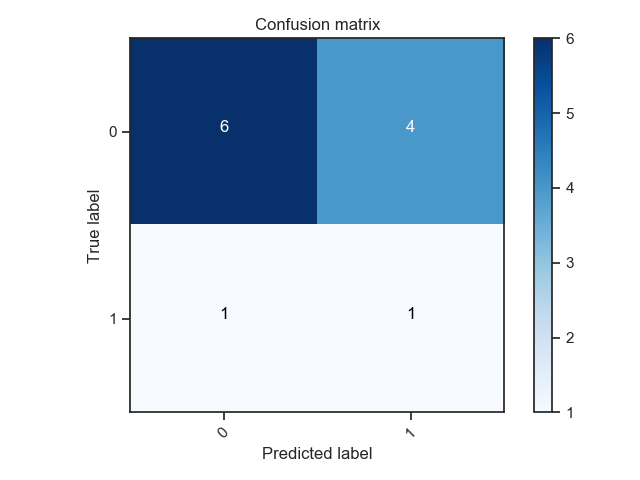

array([[6, 4],
       [1, 1]])

In [39]:
plot_confusion_matrix(cm, classes=[0, 1])

In [40]:
f1_score(y_test, y_pred)

0.28571428571428575

Not a great result on the test set for this demonstration. This is probaly due to unique terms found in the test set but not in the train set due to the lack of data. However I will train this model on the full set from this document. This model can be serialised by using pickle and then loaded later.

In [41]:
gs_lr.best_estimator_.fit(X, y)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.95, max_features=None,
                                 min_df=0.1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=<function preprocess at 0x7f701c975840>,
                                 smooth_idf=True, stop_words='english',
                                 strip_accents...=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                                    fit_i

We will emulate this approach in the training script used to train a model for the web app